In [ ]:
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="HeNPARP7EmQTxxVRpewzuqm8b",
    project_name="face-normal-liveness",
    workspace="ahmadirfaan",
)

# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

# Dataset and Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [10]:
bs = 24
crop_size = 230

transform = transforms.Compose([
  transforms.Resize((crop_size, crop_size)),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_train = datasets.ImageFolder("train", transform=transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(len(data_train) * 0.15)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)

trainloader = DataLoader(train_set, batch_size=bs)
valloader = DataLoader(val_set, batch_size=bs)

In [11]:
len(train_set), len(val_set)

(18015, 3179)

In [12]:
label2cat = data_train.classes
label2cat

['0_live', '1_spoof']

# Architecture and Config

In [4]:
import torch
from torch import nn
from efficientnet_pytorch import EfficientNet

class EfficientNetB0(nn.Module):
    def __init__(self, output_size=2):
        super().__init__()
        self.basemodel = EfficientNet.from_name('efficientnet-b0')
#         self.basemodel.set_swish(memory_efficient=False)
        self.freeze()
        self.basemodel._fc = nn.Sequential(
            nn.Linear(1280, output_size)
        )
        
#         self.basemodel.classifier = nn.Sequential(
#             nn.Linear(512, output_size),
#             nn.LogSoftmax(dim=1)
#         )
    
    def forward(self, x):
        x = self.basemodel(x)
        return x

    def freeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = True # Unfreezing Weight

    def predict(self, x):
        with torch.no_grad():
            self.basemodel.eval()
            output = self.basemodel(x)
            preds = output.argmax(1)
        return preds

In [5]:
import torch
from torch import nn
import timm

class ConvNext(nn.Module):
    def __init__(self, output_size=2):
        super().__init__()
        self.basemodel = timm.create_model("convnext_base", pretrained=False)
#         self.basemodel.set_swish(memory_efficient=False)
        self.freeze()
        self.basemodel.head.fc = nn.Sequential(
            nn.Linear(1024, output_size)
        )
        
#         self.basemodel.classifier = nn.Sequential(
#             nn.Linear(512, output_size),
#             nn.LogSoftmax(dim=1)
#         )
    
    def forward(self, x):
        x = self.basemodel(x)
        return x

    def freeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = True # Unfreezing Weight

    def predict(self, x):
        with torch.no_grad():
            self.basemodel.eval()
            output = self.basemodel(x)
            preds = output.argmax(1)
        return preds

In [6]:
class VisionTransformer(nn.Module):
    def __init__(self, output_size=2):
        super().__init__()
        self.basemodel = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.freeze()
        self.basemodel.head = nn.Sequential(
            nn.Linear(768, output_size),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.basemodel(x)
        return x

    def freeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = True # Unfreezing Weight

    def predict(self, x):
        with torch.no_grad():
            self.basemodel.eval()
            output = self.basemodel(x)
            preds = output.argmax(1)
        return preds

In [16]:
config = set_config({
    "output_size": len(data_train.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

# Training

In [7]:
model_1 = ConvNext(2).to(device)
model_2 = EfficientNetB0(2).to(device)
model_3 = VisionTransformer(2).to(device)

In [8]:
model_1.load_state_dict(torch.load('model fix/convnext.pth', map_location=device))
model_2.load_state_dict(torch.load('model fix/effnet.pth', map_location=device))
model_3.load_state_dict(torch.load('model fix/vision_transformer.pth', map_location=device))

<All keys matched successfully>

## Validation Score

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
def predict(model, test_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)    
    targets = targets.cpu().numpy()  
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out.cpu().numpy()
    probs = nn.functional.softmax(preds, dim=1).cpu().numpy()
    
    return targets, preds_out, probs

In [21]:
bs = 24
crop_size = 230

transform = transforms.Compose([
  transforms.Resize((crop_size, crop_size)),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_benchmark = datasets.ImageFolder("val", transform=transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)

benchmarkloader = DataLoader(data_benchmark, batch_size=bs)

In [22]:
target1, preds1, y_pred_prob1 = predict(model_1, benchmarkloader, device)
target2, preds2, y_pred_prob2 = predict(model_2, benchmarkloader, device)
target3, preds3, y_pred_prob3 = predict(model_3, benchmarkloader, device)

In [23]:
preds_majority_voting = []

In [24]:
for target, pred_1, pred_2, pred_3 in zip(target1, preds1, preds2, preds3):
    vote = pred_1 + pred_2 + pred_3
    if(vote >= 2):
        preds_majority_voting.append(1)
    else:
        preds_majority_voting.append(0)

In [25]:
print(classification_report(target1, preds_majority_voting, target_names=label2cat))

              precision    recall  f1-score   support

      0_live       0.97      0.98      0.97      1156
     1_spoof       0.99      0.99      0.99      4144

    accuracy                           0.99      5300
   macro avg       0.98      0.98      0.98      5300
weighted avg       0.99      0.99      0.99      5300



In [26]:
cf_matrix = confusion_matrix(target1, preds_majority_voting)
cf_matrix

array([[1132,   24],
       [  40, 4104]])

In [27]:
tn, fp, fn, tp = cf_matrix.ravel()

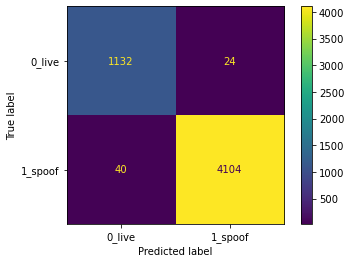

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.4g')

# Calculate Metric

In [29]:
apcer = fp / (tn + fp)
npcer = fn / (fn + tp)

acer = (apcer + npcer) / 2
tpr = tp / (tp + fn)
tnr = tn / (tn+fp)

In [30]:
print(f'APCER / FPR: {apcer*100:.{4}f}')
print(f'NPCER / FNR: {npcer*100:.{4}f}')
print(f'ACER: {acer*100:.{4}f}')
print(f'TPR: {tpr*100:.{4}f}')
print(f'TNR: {tnr*100:.{4}f}')

APCER / FPR: 2.0761
NPCER / FNR: 0.9653
ACER: 1.5207
TPR: 99.0347
TNR: 97.9239


# Challenge

In [9]:
import os
from PIL import Image

In [10]:
all_images = os.listdir('benchmark/benchmark-challenge')

In [11]:
def transform_image(image):
    # Load Image
    img = Image.open(image)
    img = img.convert('RGB')
    
    # Transform Image
    crop_size = 230

    transform = transforms.Compose([
      transforms.Resize((crop_size, crop_size)),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input = transform(img).to(device)
    input = input.unsqueeze(0)

    return input

In [12]:
from torch import nn, optim

In [13]:
def predict_image(img):
    # Support to GPU and CPU
    input = transform_image(img)
    vote = 0
    prob = 0
    for model in [model_1, model_2, model_3]:
        preds = model(input)
#         print(preds)
        _, preds_out = torch.max(preds, 1)
        preds_out = preds_out.cpu().numpy()
        probs = nn.functional.softmax(preds.detach(), dim=1).cpu().numpy()
        vote += preds_out[0]
        prob += probs[0][preds_out[0]]
#         print(probs[0][preds_out[0]])
#     print(prob/3)
    if(vote >= 2):
        return [img.split('/')[-1], 0, prob/3]
    else:
        return [img.split('/')[-1], 1, prob/3]

In [23]:
df = []

for image in all_images:
    df.append(predict_image('benchmark/benchmark-challenge/'+image))

In [15]:
predict_image('img1.jpg')

['img1.jpg', 0, 0.8929897944132487]

In [24]:
import pandas as pd

In [25]:
df_chal = pd.DataFrame(df, columns=['image', 'prediction', 'score'])

In [26]:
df_chal.to_csv('liveness_challenge.csv', index=False)

In [27]:
df_chal[df_chal.prediction == 1]

image  prediction     score
8    qzedhytmnvarils.jpg           1  0.871527
19   pcijlaazoacssyn.jpg           1  0.951265
31   gfacuzdnchxzfkj.jpg           1  0.969227
35   iztalrymtvgosdo.jpg           1  0.912758
65   cliwcinkkymkqgh.jpg           1  0.903324
..                   ...         ...       ...
959  sbvivcohrakdhya.jpg           1  0.987238
962  kjarkmpkncdxkdw.jpg           1  0.998196
983  gdmtcyrevkedpuq.jpg           1  0.944148
984  mrihclqzslzzwrp.jpg           1  0.978286
992  bvzzdsciujqwzzg.jpg           1  0.859045

[91 rows x 3 columns]